In [1]:

import csv
import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda, Convolution2D,Cropping2D, Dropout, Activation
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
#from keras.optimizers import Adam
#from keras.regularizers import l2

Using TensorFlow backend.


In [2]:
#sample names lines to append all the infomormations (feratures and labels)
samples = [] #simple array to append all the entries present in the .csv file
correction = 0.2 # angle correction for the cameras left and right

with open('./destination_path/data/driving_log.csv') as csvfile: 
    reader = csv.reader(csvfile) # read the excel file with the features and the labels
    next(reader, None)
    for line in reader:
        samples.append(line) # append the lines in the list samples


In [3]:
# 80% Training Set of the list lines  and 20% validation set of the list lines 
# 8037 Images
# Training Set = 6428 Images and Validation Set = 1609
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

In [4]:
# a generator is used to reduce the data size of the data : we build mini batch for the gradient descent
#we  create small packet, which we send sequential (we don't send all in one big packet): we win time and memory
# the mini batch method gradient descent can converge in one global minimum as a SGD
# we speak here about 6428/32= 200 steps/epoch for the training set and  1609/32=50 steps/epoch for the validation set

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = [] # list to append all the features (cameras data)
            angles = [] # list to appens all the labels (steering angle measurement)
            for batch_sample in batch_samples:
                name = './destination_path/data/IMG/'+batch_sample[0].split('/')[-1]
                #RGB conversion for treatment
                center_image = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB) 
                #data augmentation (translation):the flip fonction is used to have more data
                #deliver the steering angle measurement from the central image
                center_angle = float(batch_sample[3]) 
                images.append(center_image) 
                images.append(cv2.flip(center_image, 1))
                angles.append(center_angle)
                angles.append(center_angle*-1)
                
                # same treatment for the left image with the angle correction 
                name = './destination_path/data/IMG/'+batch_sample[1].split('/')[-1]
                left_image = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB) 
                left_angle = center_angle + correction 
                images.append(left_image) 
                images.append(cv2.flip(left_image, 1))
                angles.append(left_angle)
                angles.append(left_angle*-1)           
                
                # same treatment for the right_image with the angle correction
                name = './destination_path/data/IMG/'+batch_sample[2].split('/')[-1]
                right_image = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB) 
                right_angle = center_angle - correction
                images.append(right_image) 
                images.append(cv2.flip(right_image, 1))
                angles.append(right_angle)
                angles.append(right_angle*-1)           
        
            X_train = np.array(images) # X_train (features) 
            y_train = np.array(angles) # y_train (labels)
            
            yield shuffle(X_train, y_train) #hold the values of X_train and y_train 
            

Text(0.5, 1.0, 'Image with the camera left')

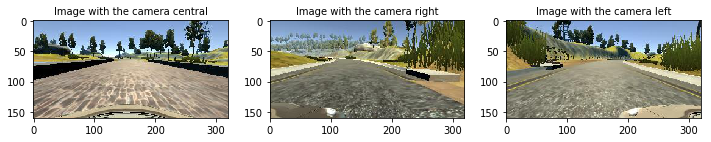

In [5]:
# Visualization normal image
image_1 = mpimg.imread('data/image_0.jpg')
image_2 = mpimg.imread('data/image_1.jpg')
image_3 = mpimg.imread('data/image_2.jpg')
    
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10, 10))
f.tight_layout()
ax1.imshow(image_1)
ax1.set_title('Image with the camera central', fontsize=10)     
ax2.imshow(image_2)
ax2.set_title('Image with the camera right', fontsize=10)
ax3.imshow(image_3)
ax3.set_title('Image with the camera left', fontsize=10)

Text(0.5, 1.0, 'Image fliped with the camera left')

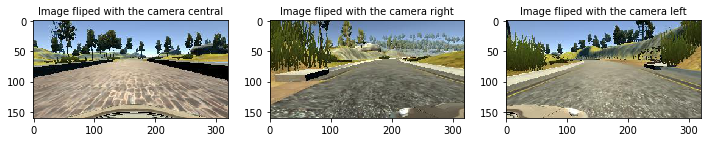

In [6]:
# Augmented data + augmented data visualization

image_flipped_1 = np.fliplr(image_1)
image_flipped_2 = np.fliplr(image_2)
image_flipped_3 = np.fliplr(image_3)

f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10, 10))
f.tight_layout()
ax1.imshow(image_flipped_1)
ax1.set_title('Image fliped with the camera central', fontsize=10)     
ax2.imshow(image_flipped_2)
ax2.set_title('Image fliped with the camera right', fontsize=10)
ax3.imshow(image_flipped_3)
ax3.set_title('Image fliped with the camera left', fontsize=10)

Text(0.5, 1.0, 'Image cropped with the camera left')

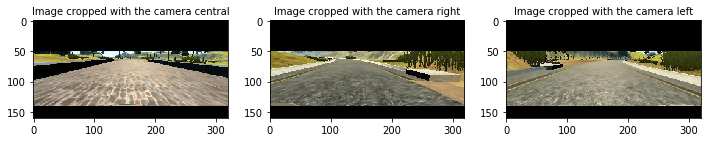

In [9]:
# Image with the cropping layer 
#the target is here to select only the part of the image important for the treatment to reduce the number of pixels
# It's a very important step before the CNN pipeline

#20 rows pixels from the top of the image
bottom_image_pixels = 20

#50 rows pixels from the top of the image
top_image_pixels = 50

#0 columns of pixels from the left of the image
#0 columns of pixels from the right of the image

pixels_bottom_start = 160 - bottom_image_pixels
pixels_top_start = 160 - top_image_pixels

Mask = np.ones((3,160,320,3),dtype=np.uint8)
Mask[0] = image_1
Mask[0,pixels_bottom_start:,:,:] = 0
Mask[0,:top_image_pixels,:,:] = 0


image_1 =  Mask[0]

Mask[1] = image_2
Mask [1,140:,:,:] = 0
Mask [1,:50,:,:] = 0
image_2 =  Mask[1]

Mask[2] = image_3
Mask [2,140:,:,:] = 0
Mask [2,:50,:,:] = 0
image_3 =  Mask[2]

f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10, 10))
f.tight_layout()
ax1.imshow(image_1)
ax1.set_title('Image cropped with the camera central', fontsize=10)     
ax2.imshow(image_2)
ax2.set_title('Image cropped with the camera right', fontsize=10)
ax3.imshow(image_3)
ax3.set_title('Image cropped with the camera left', fontsize=10)


In [10]:
# compile and train the train and the validation using the generator function with the mini_batch =32 for the gradient descent
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

In [11]:
# Start of the CNN pipeline
model = Sequential()

# image proprecessing : centered and standard deviation 
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))

# delete a part of the image not useful for the steering treatment
model.add(Cropping2D(cropping=((50,20), (0,0))))


#Layer 1- Convolution, 24 filters, size= 5x5, stride= 2x2, activation relu
model.add(Convolution2D(24,(5,5), activation='relu', strides=(2,2)))

#Layer 2- Convolution, 36 filters, size= 5x5, stride= 2x2, activation relu
model.add(Convolution2D(36,(5,5), activation='relu', strides=(2,2)))

#Layer 3- Convolution, 48 filters, size= 5x5, stride= 2x2, activation relu
model.add(Convolution2D(48,(5,5), activation='relu', strides=(2,2)))

#Layer 4- Convolution, 64 filters, size= 3x3,stride= 1x1,  activation relu
model.add(Convolution2D(64,(3,3), activation='relu'))

#Layer 5- Convolution, 64 filters, size= 3x3,stride= 1x1,  activation relu
model.add(Convolution2D(64,(3,3), activation='relu'))

#Layer 6- Conversion in one vector unidimensional 
model.add(Flatten())

#Layer 7 - Full Connected Layer 1 with 20% dropout of the layers to decrease the overfitting
model.add(Dense(100,activation='relu'))
# L2 Regularization to decrease the overfitting
#model.add(Dense(100,activity_regularizer=l2(0.0001)))
model.add(Dropout(0.2))

#Layer 8 - Full Connected Layer 2 with 20% dropout of the layers to decrease the overfitting
model.add(Dense(50,activation='relu'))
# L2 Regularization to decrease the overfitting
#model.add(Dense(50,activity_regularizer=l2(0.0001))
model.add(Dropout(0.2))

#Layer 9 - Full Connected Layer 3
model.add(Dense(10,activation='relu'))

# Ouput : vehicule controls : steering controls
model.add(Dense(1))

In [12]:
#Adam configuration, beta1/momentum =dw, beta2/RMS prop=dw2
#optimizer = Adam(lr=0.001 , beta_1=0.9, beta_2=0.999, epsilon=1e-08)
#mean squared error for the loss function : standard algo for regression problem
model.compile(loss='mse',optimizer='adam')

#fit generator for the training set and the validation set
# only two epochs are useful, but in reality it will be interessant to make 5 or 10 epoch to be sure to find a global minimum
# We have 200 steps/epochs for the training set (6428/32) and 50 steps/epochs for the validation set (1609/32)
history = model.fit_generator(train_generator, steps_per_epoch= len(train_samples)/32, epochs=5, validation_data=validation_generator, validation_steps=len(validation_samples)/32, verbose=1)

Epoch 1/5
201/200 [==============================] - 1008s 5s/step - loss: 0.0211 - val_loss: 0.0159
Epoch 2/5
201/200 [==============================] - 1028s 5s/step - loss: 0.0169 - val_loss: 0.0150
Epoch 3/5
201/200 [==============================] - 1041s 5s/step - loss: 0.0157 - val_loss: 0.0143
Epoch 4/5
201/200 [==============================] - 1180s 6s/step - loss: 0.0145 - val_loss: 0.0135
Epoch 5/5
201/200 [==============================] - 1048s 5s/step - loss: 0.0137 - val_loss: 0.0129


In [13]:
# keras method to print the model summary
model.summary()

#saving model
model.save('model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 43, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 37, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 35, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 33, 64)         36928     
__________

Text(0.5, 1.0, 'Pipeline SW')

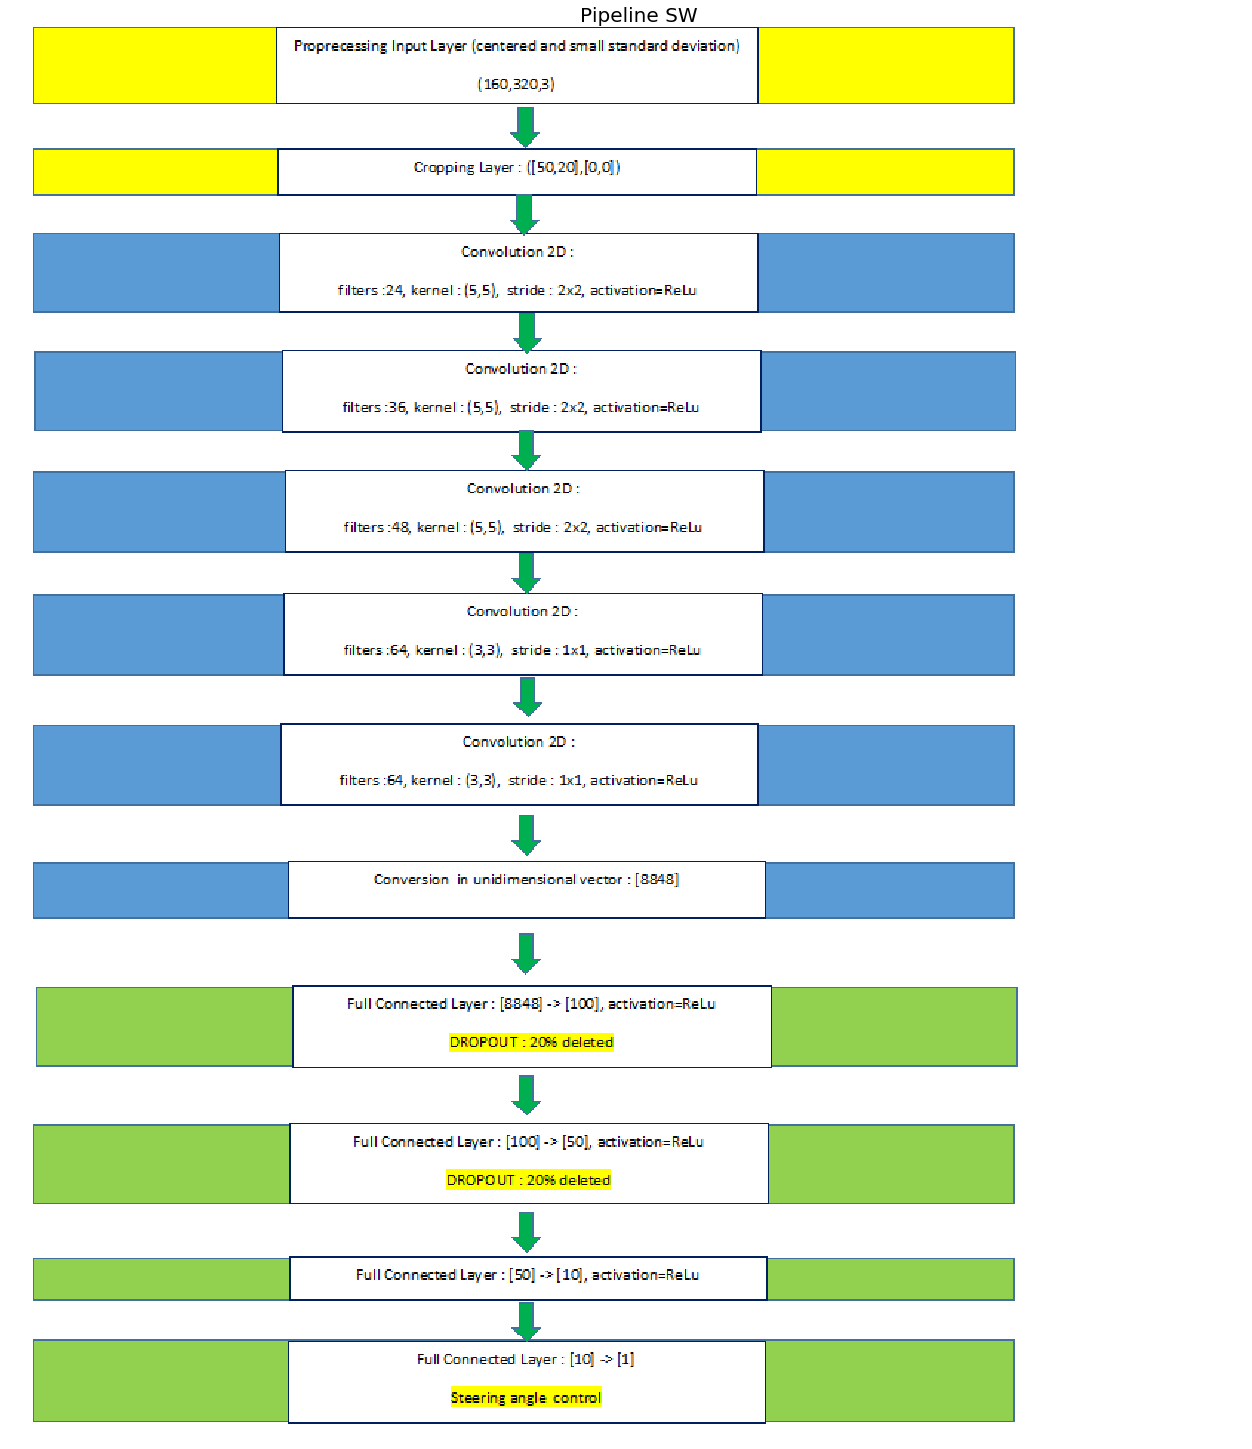

In [14]:
# Pipeline Vizualizalization

image = mpimg.imread('pipeline.png')
f, (ax1) = plt.subplots(1, figsize=(20, 20))
f.tight_layout()
ax1.axis('off')
ax1.imshow(image)
ax1.set_title('Pipeline SW', fontsize=20)     

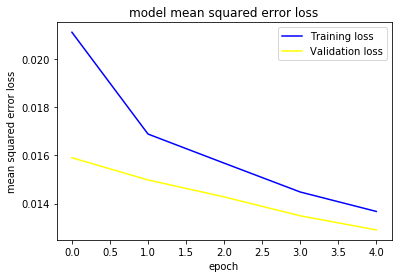

<Figure size 432x288 with 0 Axes>

In [17]:
# plot the training and the validation loss for each epoch to evaluate the accuracy

plt.plot(history.history['loss'],label='Training loss',color='blue')
plt.plot(history.history['val_loss'],label='Validation loss',color='yellow')

plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

# save the results
plt.savefig('Training_And_Validation_loss.jpg')
